Epoch 1/100


C:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


440/440 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1604
Epoch 2/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0854
Epoch 3/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0770
Epoch 4/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0778
Epoch 5/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0729
Epoch 6/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0800
Epoch 7/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0721
Epoch 8/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0750
Epoch 9/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0788
Epoch 10/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0712
Epoch 11/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0745
Epoch 12/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0762
Epoch 13/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0727
Epoch 14/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0710
Epoch 15/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

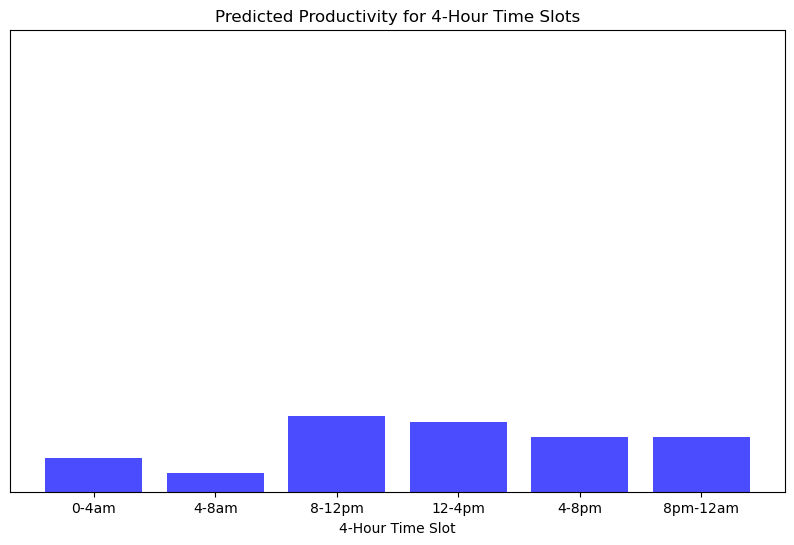

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Load Dataset 1 (Poductivity_Test.csv)
data1 = pd.read_csv(r"C:\Users\ashut\OneDrive\Documents\Poductivity_Test.csv")
data1.columns = ['Day', 'hour_slot', 'productivity_rating']

# Convert 'hour_slot' to a numerical feature (extract the starting hour)
data1['hour_slot'] = data1['hour_slot'].apply(lambda x: int(x.split('-')[0]))

# Load Dataset 2 (student_schedule.csv)
data2 = pd.read_csv(r"C:\Users\ashut\OneDrive\Documents\student_productivity.csv")

# Convert day_of_week to numerical and time_of_day to hour slots
data2['day_of_week'] = data2['day_of_week'].map({
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
})
data2['time_of_day'] = data2['time_of_day'].str.replace(':00', '').astype(int)

# Create 4-hour slots for dataset 2
def get_time_slot(hour):
    if 0 <= hour < 4:
        return 0
    elif 4 <= hour < 8:
        return 1
    elif 8 <= hour < 12:
        return 2
    elif 12 <= hour < 16:
        return 3
    elif 16 <= hour < 20:
        return 4
    else:
        return 5

data2['time_slot'] = data2['time_of_day'].apply(get_time_slot)

# Prepare the unified dataset using just the time slots (X) and productivity (Y)
time_slots_1 = data1['hour_slot'].values
productivity_1 = data1['productivity_rating'].values

time_slots_2 = data2['time_slot'].values
productivity_2 = data2['productivity'].values

# Unify both datasets by stacking them together
X = np.concatenate([time_slots_1, time_slots_2], axis=0)
y = np.concatenate([productivity_1, productivity_2], axis=0)

# Normalize the features (time slots)
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X.reshape(-1, 1))

# Reshape the input for LSTM model (LSTM expects 3D input)
X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=32))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Evaluate the model
y_pred = model.predict(X_test)
mse = np.mean(np.square(y_pred - y_test))
print(f'Mean Squared Error: {mse}')

# Predict productivity for all time slots
predicted_productivity = model.predict(X_lstm)

# Calculate the average predicted productivity for each 4-hour slot (0-5)
avg_productivity = []
for slot in range(6):
    slot_productivity = predicted_productivity[X == slot]
    if len(slot_productivity) > 0:
        avg_productivity.append(np.mean(slot_productivity))
    else:
        avg_productivity.append(0)  # If no data exists for a slot, use 0

# Create the bar plot for 4-hour slots
time_labels = ['0-4am', '4-8am', '8-12pm', '12-4pm', '4-8pm', '8pm-12am']

plt.figure(figsize=(10, 6))
plt.bar(time_labels, avg_productivity, color='blue', alpha=0.7)
plt.xlabel('4-Hour Time Slot')
plt.title('Predicted Productivity for 4-Hour Time Slots')
plt.ylim(0, 5)  # Ensure the y-axis goes from 0 to 10 for clarity
plt.yticks([])
plt.show()
